# Community detection in the network "Les Misérables" via OtrisymNMF

 The network derived from Les Misérables represent the co-occurrences of the main characters in Victor Hugo's famous novel. In this network, the vertices represent characters, and the weight of the edge between two characters corresponds to the number of scenes in which they appear together.

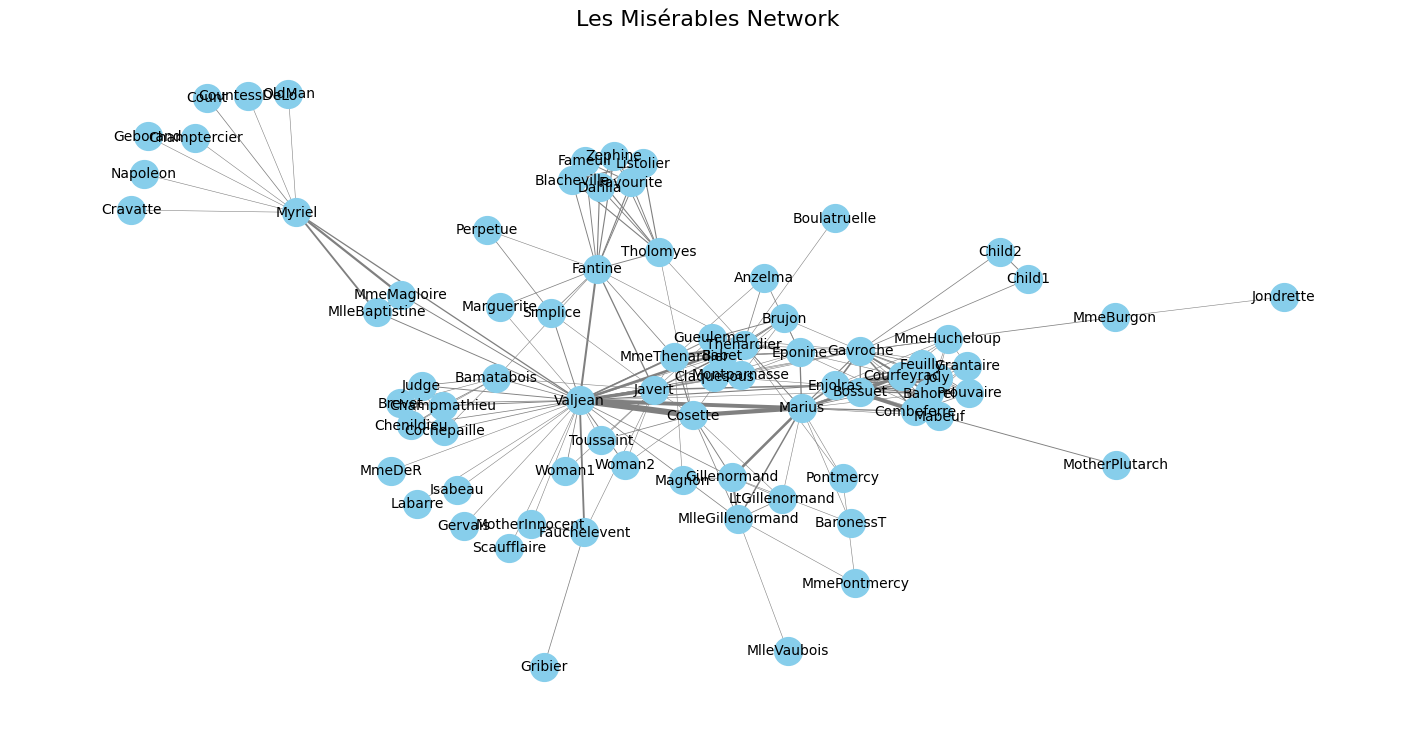

In [5]:
import networkx as nx
import matplotlib.pyplot as plt

# Load of the network "Les Misérables"
G = nx.read_gml('Data/lesmiserables.gml')

# Network display
pos = nx.spring_layout(G, seed=12)
raw_weights = [G[u][v]['value'] for u, v in G.edges()]
min_w = min(raw_weights)
max_w = max(raw_weights)
edge_widths2 = [0.4 + 4* (w - min_w) / (max_w - min_w) for w in raw_weights]
plt.figure(figsize=(18, 9))
nx.draw_networkx_edges(G, pos, width=edge_widths2, edge_color='gray')
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=400)
nx.draw_networkx_labels(G, pos, font_size=10)

plt.title("Les Misérables Network", fontsize=16)
plt.axis('off')
plt.show()

## Selecting the value of r, the number of communities

We aim to use OtrisymNMF to detect communities within the network. Since the number of communities r is unknown, we need to select a reasonable value for it.

To do this, we rely on the elbow method. This technique involves plotting the reconstruction error as a function of r, and identifying the point where the error reduction starts to level off — known as the elbow of the curve. Beyond this point, increasing r no longer significantly improves the reconstruction.

This approach allows us to choose a value of r that captures the general structure of the network while avoiding overfitting by adding unnecessary complexity.



C:\Users\alexi\Documents\OtrisymNMF_DCBM\OtrisymNMF\OtrisymNMF_CD.py:98: RuntimeWarning: invalid value encountered in divide
  w = np.where(nw[v] != 0, w / nw[v], 0)


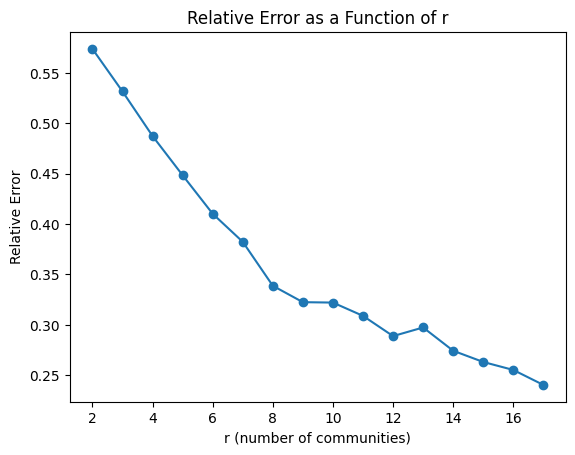

In [6]:
import OtrisymNMF
import matplotlib.pyplot as plt
X = nx.adjacency_matrix(G,weight='value') # adjacency matrix of the graph
errors=[]
r_listes=range(2,18)
for r in r_listes : # compute the factorization for different values of r
    w, v, S, error = OtrisymNMF.OtrisymNMF_CD(X,r,numTrials=40,verbosity=0)
    errors.append(error)
# Plot of the relative reconstruction error as a function of r
plt.plot(r_listes,errors,marker='o')
plt.title('Relative Error as a Function of r')
plt.xlabel('r (number of communities)')
plt.ylabel('Relative Error')
plt.show()

We choose r = 8, since the reconstruction error does not decrease significantly after this value.
## Community detection via OtrisymNMF with the chosen value of r
We detect the communities using OtrisymNMF with the selected value of r. Our method gives :
- v is a vector of length n (with n being the number of nodes) indicating the community index for each node.
- w is a vector of length n indicating the  importance of a node within its community.
- S describes interactions between the r communities.


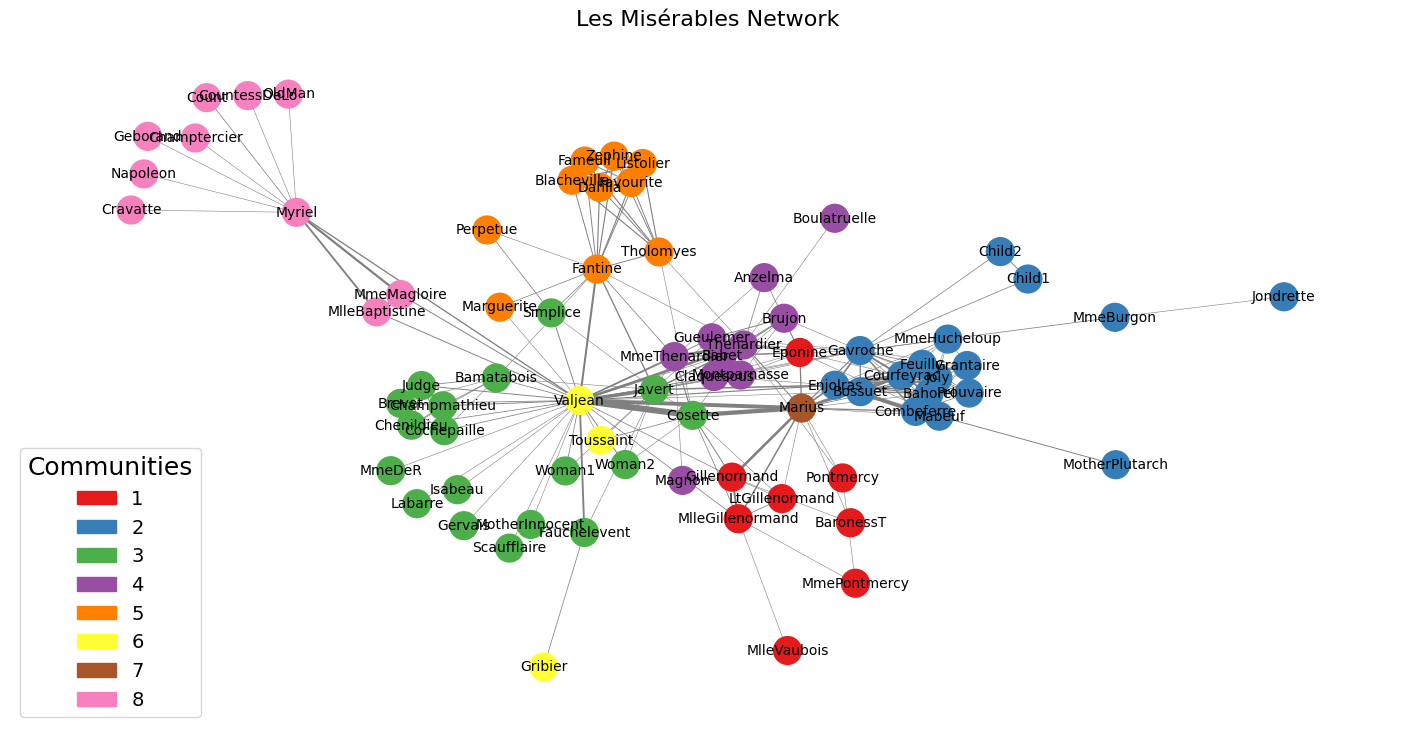

In [8]:
import matplotlib.patches as mpatches
import random


random.seed(45)
# Detection of 8 communities with OtrisymNMF

X = nx.adjacency_matrix(G,weight='value') # adjacency matrix of the graph
r=8
w, v, S, error = OtrisymNMF.OtrisymNMF_CD(X,r,numTrials=50,verbosity=0,delta=1e-6)


# Graph Display with labels v

colors = [
    '#E41A1C',  # rouge vif
    '#377EB8',  # bleu soutenu
    '#4DAF4A',  # vert modéré
    '#984EA3',  # violet foncé
    '#FF7F00',  # orange vif
    '#FFFF33',  # jaune lumineux
    '#A65628',  # brun terre
    '#F781BF'   # rose doux
]
node_list = list(G.nodes())
node_colors = [colors[v[i]] for i in range(len(node_list))]
pos = nx.spring_layout(G, seed=12)
raw_weights = [G[u][v]['value'] for u, v in G.edges()]
min_w = min(raw_weights)
max_w = max(raw_weights)
edge_widths2 = [0.4 + 4* (w - min_w) / (max_w - min_w) for w in raw_weights]
plt.figure(figsize=(18, 9))
nx.draw_networkx_edges(G, pos, width=edge_widths2, edge_color='gray')
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=400)
nx.draw_networkx_labels(G, pos, font_size=10)
legend_patches = []
for i in range(r):  # 8 communities
    patch = mpatches.Patch(color=colors[i], label=f'{i+1}')
    legend_patches.append(patch)

plt.legend(handles=legend_patches, loc='lower left', fontsize=14, title_fontsize=18, title="Communities")

plt.title("Les Misérables Network", fontsize=16)
plt.axis('off')
plt.show()



The eight communities identified by OtrisymNMF in the network, with each community represented by a distinct color

## Visualization of community interactions using the matrix S

Community: 1: ['Pontmercy', 'Eponine', 'Gillenormand', 'MlleGillenormand', 'MmePontmercy', 'MlleVaubois', 'LtGillenormand', 'BaronessT']
Community: 2: ['Jondrette', 'MmeBurgon', 'Gavroche', 'Mabeuf', 'Enjolras', 'Combeferre', 'Prouvaire', 'Feuilly', 'Courfeyrac', 'Bahorel', 'Bossuet', 'Joly', 'Grantaire', 'MotherPlutarch', 'Child1', 'Child2', 'MmeHucheloup']
Community: 3: ['Labarre', 'MmeDeR', 'Isabeau', 'Gervais', 'Cosette', 'Javert', 'Fauchelevent', 'Bamatabois', 'Simplice', 'Scaufflaire', 'Woman1', 'Judge', 'Champmathieu', 'Brevet', 'Chenildieu', 'Cochepaille', 'Woman2', 'MotherInnocent']
Community: 4: ['MmeThenardier', 'Thenardier', 'Boulatruelle', 'Anzelma', 'Magnon', 'Gueulemer', 'Babet', 'Claquesous', 'Montparnasse', 'Brujon']
Community: 5: ['Marguerite', 'Tholomyes', 'Listolier', 'Fameuil', 'Blacheville', 'Favourite', 'Dahlia', 'Zephine', 'Fantine', 'Perpetue']
Community: 6: ['Valjean', 'Gribier', 'Toussaint']
Community: 7: ['Marius']
Community: 8: ['Myriel', 'Napoleon', 'MlleB

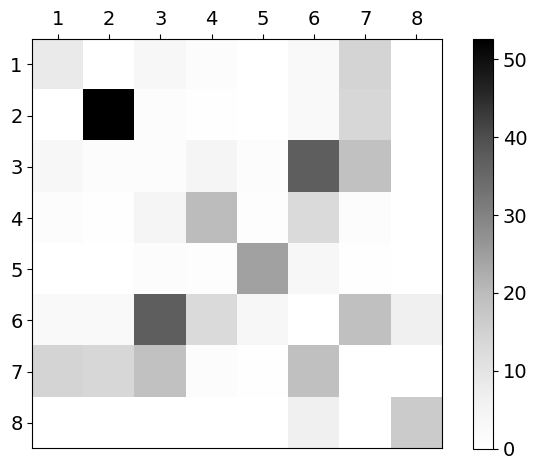

In [9]:
import numpy as np
# Print the communities
for i in range(max(v)+1):
    index=np.where(v == i)[0]
    print(f"Community: {i+1}: {[list(G.nodes())[j] for j in index] }")
# Display of S with a heatmap
plt.imshow(S,cmap='Greys')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
plt.gca().xaxis.set_ticks_position('top')
plt.gca().xaxis.set_label_position('top')
labels = np.arange(1, S.shape[0] + 1)
plt.xticks(fontsize=14,ticks=np.arange(S.shape[1]), labels=labels)
plt.yticks(fontsize=14,ticks=np.arange(S.shape[0]), labels=labels)
#plt.title("Heatmap of matrix S\nInteraction between the communities", pad=30)
# plt.xlabel('Community j')
# plt.ylabel('Community i')
plt.tight_layout()
plt.show()

In [10]:
print(X[72,:])
print(node_list[11])
print(node_list[26])
print(node_list[27])

  (0, 11)	1
  (0, 26)	2
  (0, 27)	1
Valjean
Cosette
Javert


## Community detection via DCBM (initialization SVCA)

Best logP : -2636.3296265240297
 Normalized mutual information between the partition found by DCBM and the one found by OtrisymNMF :0.7661654725499623


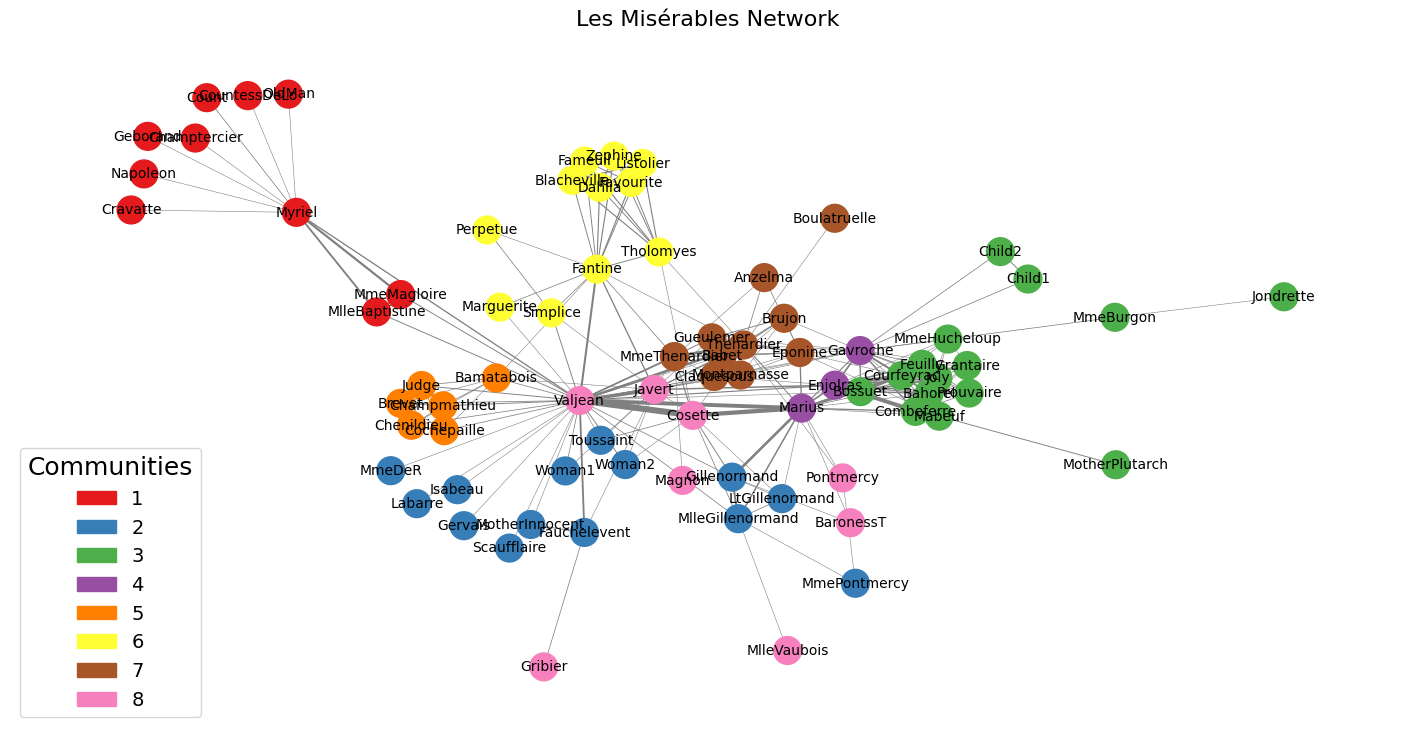

In [12]:
import pysbm
from Utils import DC_BM
from sklearn.metrics import normalized_mutual_info_score as NMI

DCBM_partition=DC_BM(G,8,pysbm.DegreeCorrectedUnnormalizedLogLikelyhood,pysbm.EMInference, numTrials=100,verbosity=1,tri=False)
print(f" Normalized mutual information between the partition found by DCBM and the one found by OtrisymNMF :{NMI(DCBM_partition,v)}")
# Graph Display with labels v

colors = [
    '#E41A1C',  # rouge vif
    '#377EB8',  # bleu soutenu
    '#4DAF4A',  # vert modéré
    '#984EA3',  # violet foncé
    '#FF7F00',  # orange vif
    '#FFFF33',  # jaune lumineux
    '#A65628',  # brun terre
    '#F781BF'   # rose doux
]
node_list = list(G.nodes())
node_colors = [colors[DCBM_partition[i]] for i in range(len(node_list))]
pos = nx.spring_layout(G, seed=12)
raw_weights = [G[u][v]['value'] for u, v in G.edges()]
min_w = min(raw_weights)
max_w = max(raw_weights)
edge_widths2 = [0.4 + 4* (w - min_w) / (max_w - min_w) for w in raw_weights]
plt.figure(figsize=(18, 9))
nx.draw_networkx_edges(G, pos, width=edge_widths2, edge_color='gray')
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=400)
nx.draw_networkx_labels(G, pos, font_size=10)
legend_patches = []
for i in range(r):  # 8 communities
    patch = mpatches.Patch(color=colors[i], label=f'{i+1}')
    legend_patches.append(patch)

plt.legend(handles=legend_patches, loc='lower left', fontsize=14, title_fontsize=18, title="Communities")

plt.title("Les Misérables Network", fontsize=16)
plt.axis('off')
plt.show()


Best logP : -2643.3959032589246
 Normalized mutual information between the partition found by DCBM and the one found by OtrisymNMF :0.7225467076575122


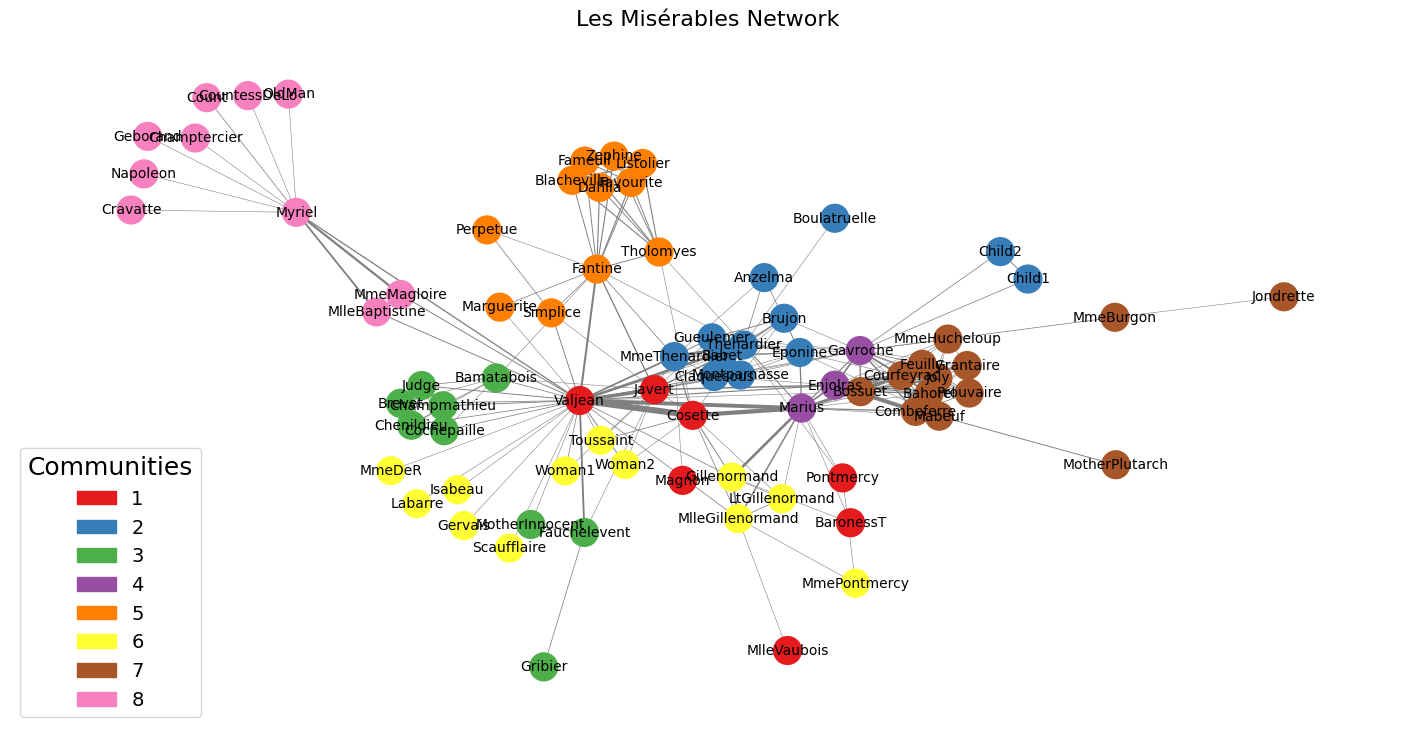

In [13]:
import pysbm
from Utils import DC_BM
from sklearn.metrics import normalized_mutual_info_score as NMI

DCBM_partition=DC_BM(G,8,pysbm.DegreeCorrectedUnnormalizedLogLikelyhood,pysbm.EMInference, numTrials=100,verbosity=1,tri=False,init_method="SVCA")
print(f" Normalized mutual information between the partition found by DCBM and the one found by OtrisymNMF :{NMI(DCBM_partition,v)}")
# Graph Display with labels v

colors = [
    '#E41A1C',  # rouge vif
    '#377EB8',  # bleu soutenu
    '#4DAF4A',  # vert modéré
    '#984EA3',  # violet foncé
    '#FF7F00',  # orange vif
    '#FFFF33',  # jaune lumineux
    '#A65628',  # brun terre
    '#F781BF'   # rose doux
]
node_list = list(G.nodes())
node_colors = [colors[DCBM_partition[i]] for i in range(len(node_list))]
pos = nx.spring_layout(G, seed=12)
raw_weights = [G[u][v]['value'] for u, v in G.edges()]
min_w = min(raw_weights)
max_w = max(raw_weights)
edge_widths2 = [0.4 + 4* (w - min_w) / (max_w - min_w) for w in raw_weights]
plt.figure(figsize=(18, 9))
nx.draw_networkx_edges(G, pos, width=edge_widths2, edge_color='gray')
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=400)
nx.draw_networkx_labels(G, pos, font_size=10)
legend_patches = []
for i in range(r):  # 8 communities
    patch = mpatches.Patch(color=colors[i], label=f'{i+1}')
    legend_patches.append(patch)

plt.legend(handles=legend_patches, loc='lower left', fontsize=14, title_fontsize=18, title="Communities")

plt.title("Les Misérables Network", fontsize=16)
plt.axis('off')
plt.show()

Best logP : -2641.61372996585
 Normalized mutual information between the partition found by DCBM and the one found by OtrisymNMF :0.7180549557914148


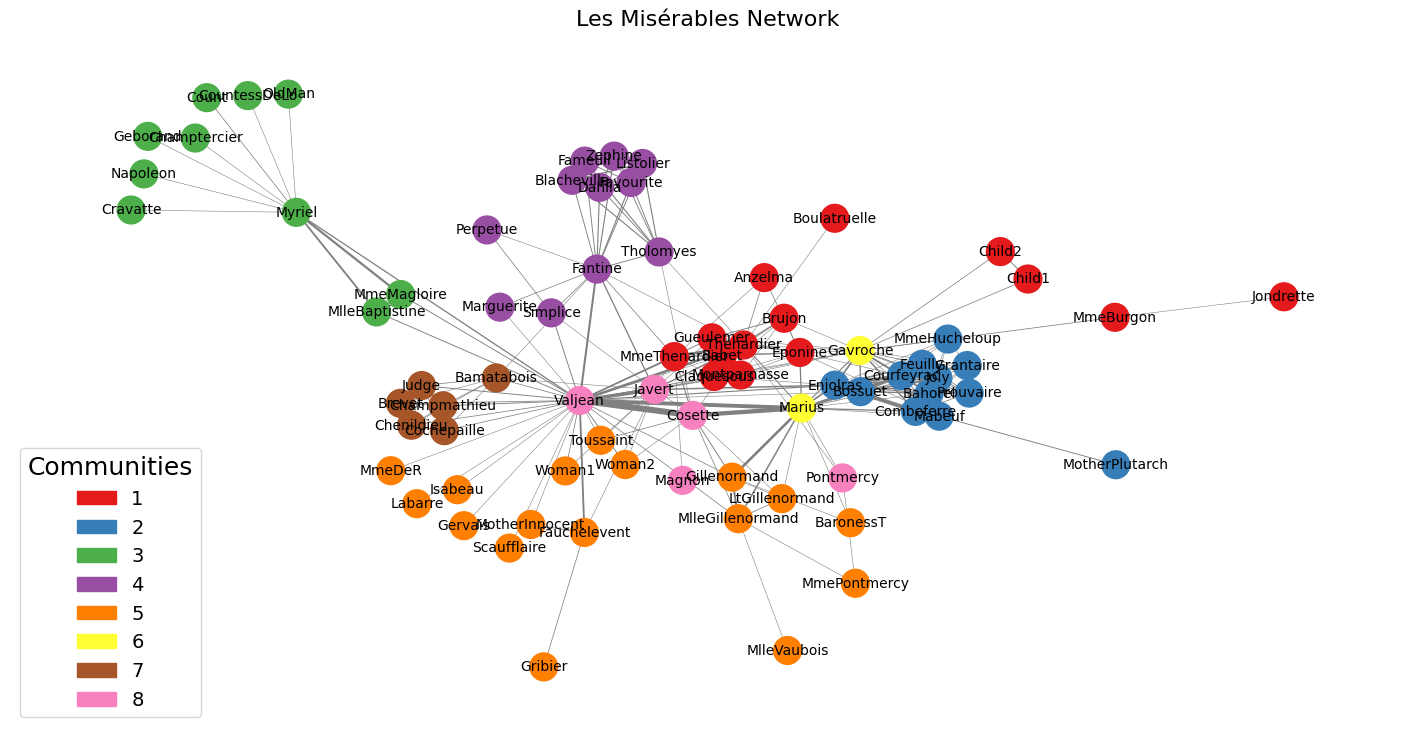

Best logP : -2708.974742677568
 Normalized mutual information between the partition found by DCBM and the one found by OtrisymNMF :0.5663323843816361


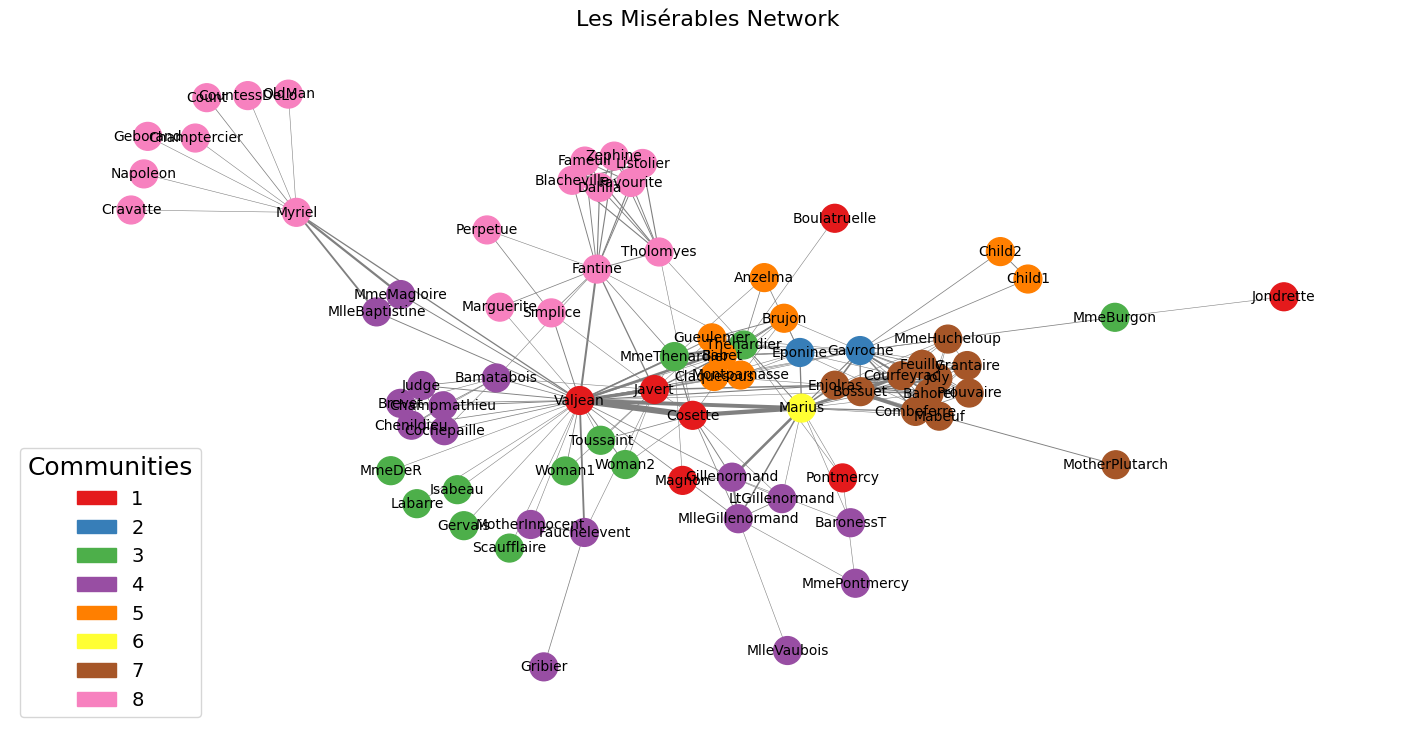

In [14]:
import pysbm
from Utils import DC_BM
from sklearn.metrics import normalized_mutual_info_score as NMI

DCBM_partition = DC_BM(G, 8, pysbm.DegreeCorrectedUnnormalizedLogLikelyhood, pysbm.EMInference, numTrials=100,
                       verbosity=1, tri=False, init_method="SVCA")
print(
    f" Normalized mutual information between the partition found by DCBM and the one found by OtrisymNMF :{NMI(DCBM_partition, v)}")
# Graph Display with labels v

colors = [
    '#E41A1C',  # rouge vif
    '#377EB8',  # bleu soutenu
    '#4DAF4A',  # vert modéré
    '#984EA3',  # violet foncé
    '#FF7F00',  # orange vif
    '#FFFF33',  # jaune lumineux
    '#A65628',  # brun terre
    '#F781BF'  # rose doux
]
node_list = list(G.nodes())
node_colors = [colors[DCBM_partition[i]] for i in range(len(node_list))]
pos = nx.spring_layout(G, seed=12)
raw_weights = [G[u][v]['value'] for u, v in G.edges()]
min_w = min(raw_weights)
max_w = max(raw_weights)
edge_widths2 = [0.4 + 4 * (w - min_w) / (max_w - min_w) for w in raw_weights]
plt.figure(figsize=(18, 9))
nx.draw_networkx_edges(G, pos, width=edge_widths2, edge_color='gray')
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=400)
nx.draw_networkx_labels(G, pos, font_size=10)
legend_patches = []
for i in range(r):  # 8 communities
    patch = mpatches.Patch(color=colors[i], label=f'{i + 1}')
    legend_patches.append(patch)

plt.legend(handles=legend_patches, loc='lower left', fontsize=14, title_fontsize=18, title="Communities")

plt.title("Les Misérables Network", fontsize=16)
plt.axis('off')
plt.show()

import pysbm
from Utils import DC_BM
from sklearn.metrics import normalized_mutual_info_score as NMI

DCBM_partition = DC_BM(G, 8, pysbm.DegreeCorrectedUnnormalizedLogLikelyhood, pysbm.EMInference, numTrials=1,verbosity=1, tri=False, init_method="random")
print(
    f" Normalized mutual information between the partition found by DCBM and the one found by OtrisymNMF :{NMI(DCBM_partition, v)}")
# Graph Display with labels v

colors = [
    '#E41A1C',  # rouge vif
    '#377EB8',  # bleu soutenu
    '#4DAF4A',  # vert modéré
    '#984EA3',  # violet foncé
    '#FF7F00',  # orange vif
    '#FFFF33',  # jaune lumineux
    '#A65628',  # brun terre
    '#F781BF'  # rose doux
]
node_list = list(G.nodes())
node_colors = [colors[DCBM_partition[i]] for i in range(len(node_list))]
pos = nx.spring_layout(G, seed=12)
raw_weights = [G[u][v]['value'] for u, v in G.edges()]
min_w = min(raw_weights)
max_w = max(raw_weights)
edge_widths2 = [0.4 + 4 * (w - min_w) / (max_w - min_w) for w in raw_weights]
plt.figure(figsize=(18, 9))
nx.draw_networkx_edges(G, pos, width=edge_widths2, edge_color='gray')
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=400)
nx.draw_networkx_labels(G, pos, font_size=10)
legend_patches = []
for i in range(r):  # 8 communities
    patch = mpatches.Patch(color=colors[i], label=f'{i + 1}')
    legend_patches.append(patch)

plt.legend(handles=legend_patches, loc='lower left', fontsize=14, title_fontsize=18, title="Communities")

plt.title("Les Misérables Network", fontsize=16)
plt.axis('off')
plt.show()

## Tests initialization by SVCA compared to random à supprimer

In [ ]:
import OtrisymNMF
import pysbm
from Utils import DC_BM
from sklearn.metrics import normalized_mutual_info_score as NMI
import random
import numpy as np
partition_optimal=
random.seed(42)
nb_tests=100
trials=10
NMI_moyen={"OtrisymNMF_rdm":[],"OtrisymNMF_SVCA":[],"KL_EM_rdm":[],"KL_EM_SVCA":[]}
for test in range(nb_tests):

    # OtrsisymNMF rdm
    w, v, S, error = OtrisymNMF.OtrisymNMF_CD(X,5,numTrials=trials,verbosity=0,init_method="random")
    NMI_moyen["OtrisymNMF_rdm"].append(NMI(v,partition_optimal))

    # OtrisymNMF SVCA
    w, v, S, error = OtrisymNMF.OtrisymNMF_CD(X,5,numTrials=trials,verbosity=0,init_method="SVCA")
    NMI_moyen["OtrisymNMF_SVCA"].append(NMI(v,partition_optimal))

    # KL_EM rdm
    DCBM_partition=DC_BM(G,5,pysbm.DegreeCorrectedUnnormalizedLogLikelyhood,pysbm.EMInference, numTrials=trials,verbosity=0,tri=False,init_method="random")
    NMI_moyen["KL_EM_rdm"].append(NMI(DCBM_partition,partition_optimal))

    # KL_EM SVCA
    DCBM_partition=DC_BM(G,5,pysbm.DegreeCorrectedUnnormalizedLogLikelyhood,pysbm.EMInference, numTrials=trials,verbosity=0,tri=False,init_method="SVCA")
    NMI_moyen["KL_EM_SVCA"].append(NMI(DCBM_partition,partition_optimal))

for algo in ["OtrisymNMF_rdm","OtrisymNMF_SVCA","KL_EM_rdm","KL_EM_SVCA"]:
    print(f"NMI moyen pour {algo} : {np.mean(NMI_moyen[algo])} +- {np.std(NMI_moyen[algo])}")
